## Check observables given a results file from a `TRSL` simulation

The purpose of this notebook is to compare some results of the `TRSL` model against real world observables in order to test the calibration.

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes

In [1]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151006_1537_1800s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [3]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

The following pickle file contains the simulation results:

Make file readable by `ipython` in case it was created by `pypy`:

In [4]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [5]:
results = pkl.load(open(filepath))

### 1. Protein production rate

In [6]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [7]:
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

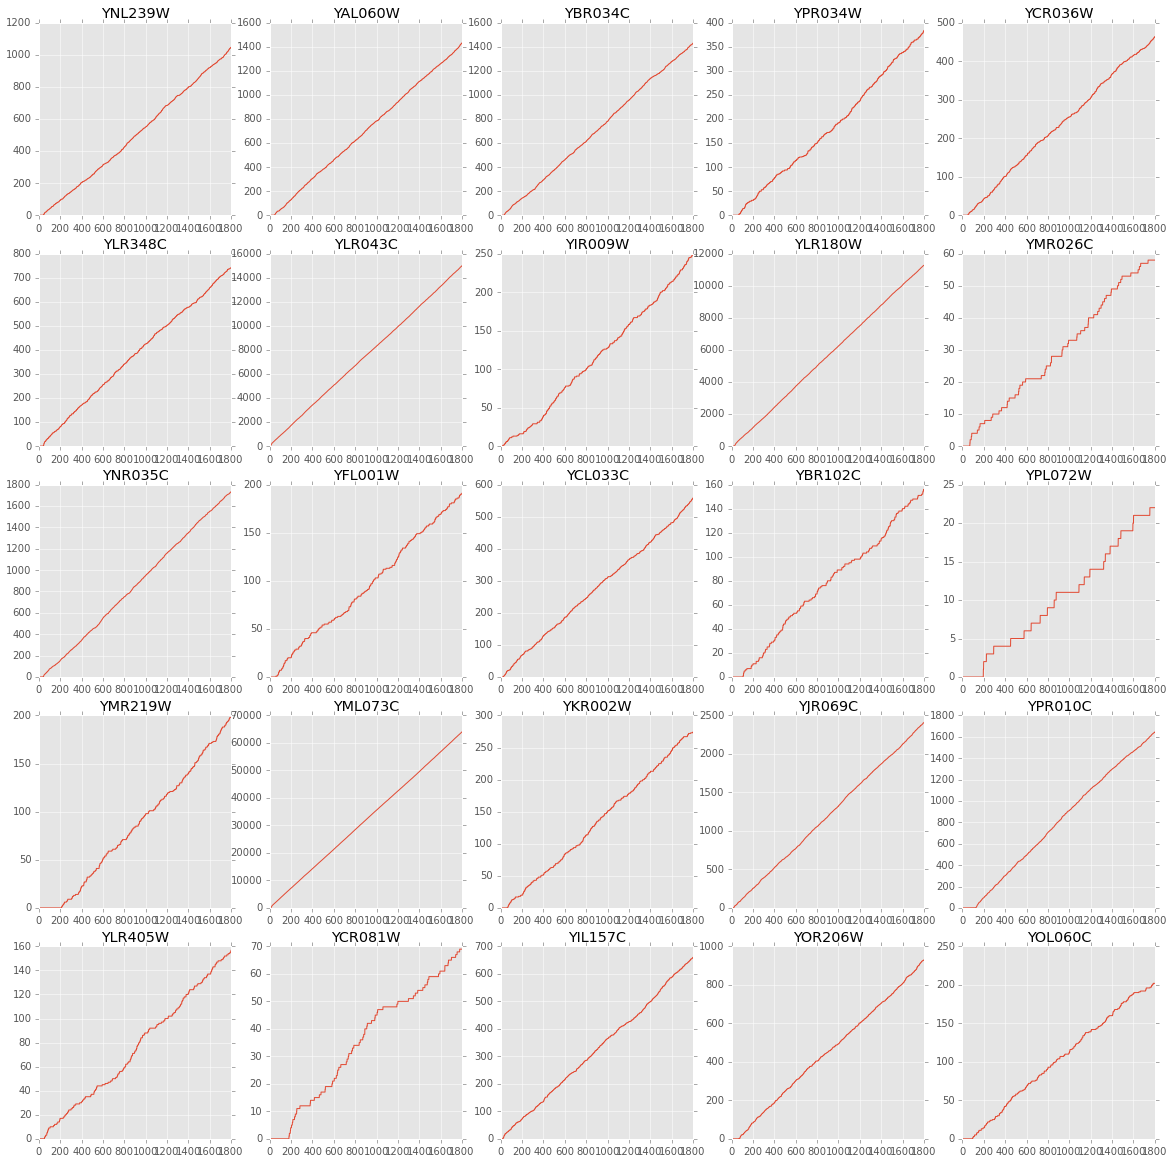

In [8]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        xseries = results['timerange']
        yseries = results['timecourses'][protnames_plot[i][j]]
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_title(protnames_plot[i][j])

For each protein, calculate speed of translation:

In [9]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 168.106213001
YAL038W 141.905747126
YJL189W 133.265517241
YCR012W 129.583908046
YOL086C 136.268751078
YLR110C 124.43991034
YLR044C 222.861494253
YKL152C 132.82659923


In [10]:
pd.Series(prot_speeds.values()).describe()

count    4475.000000
mean        1.546309
std         9.027472
min         0.000575
25%         0.055749
50%         0.141954
75%         0.432759
max       222.861494
dtype: float64

Distribution of translation speeds (finished protein molecules per second, every protein is one datapoint):

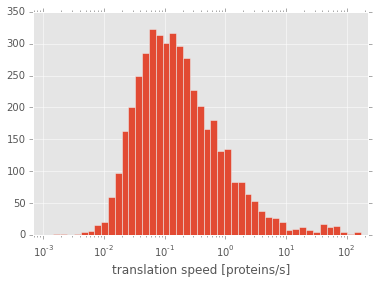

In [11]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]')
plt.show()

We next compare this with experimental values by Arava et al. (http://www.pnas.org/content/100/7/3889.full):

In [12]:
prot_exp = pkl.load(open("../parameters/prot_arava.p"))
prot_exp = {gene: prot_exp[gene] for gene in prot_exp if prot_exp[gene] > 1e-16}

In [13]:
pd.Series(prot_exp).describe()

count    5643.000000
mean        0.341868
std         1.122374
min         0.000708
25%         0.038661
50%         0.102964
75%         0.257080
max        22.142236
dtype: float64

Function to plot two dictionaries by their values:

In [14]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

4188


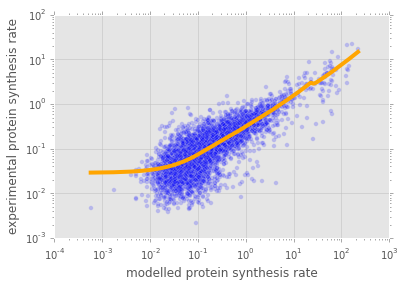

In [15]:
scatter_dicts(prot_speeds, prot_exp, "modelled protein synthesis rate", "experimental protein synthesis rate")

Reasonable correlation between modelled and experimental values.

In [16]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [17]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [18]:
pd.Series(peptide_speeds.values()).describe()

count      4475.000000
mean        454.971264
std        3049.108656
min           0.511494
25%          25.563665
50%          61.103512
75%         171.155492
max      125693.882759
dtype: float64

Distribution of speeds of peptide bond creation (peptide bonds per second, every protein is one datapoint):

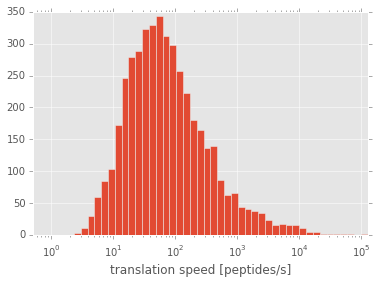

In [19]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [20]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
init_rates_plotkin_old = pkl.load(open('../parameters/init_rates_plotkin_old_2.p'))
print len(init_rates_plotkin)
print len(init_rates_plotkin_old)

4839
2569


In [21]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin.p'))
transcriptome_shah = pkl.load(open('../parameters/transcriptome_shah.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())
print len(transcriptome_shah)
print sum(transcriptome_shah.values())

4839
60000
4839
60006


In [22]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates_plotkin']

df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
df3.columns = ['name', 'transcriptome_plotkin']

df4 = pd.DataFrame.from_dict(transcriptome_shah.items())
df4.columns = ['name', 'transcriptome_shah']

In [23]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df4, left_on='name', right_on='name', how='outer')
df[:20]

,name,peptide_speeds,init_rates_plotkin,transcriptome_plotkin,transcriptome_shah
0,YBR177C,173.006897,0.000002,8,6
1,YIL140W,85.246279,0.000002,5,2
2,YLR268W,108.117816,0.000002,10,8
3,YOR011W,8.017241,0.000000,3,1
4,YPL043W,356.010345,0.000002,11,7
5,YJL155C,20.567241,0.000001,2,1
6,YLL062C,18.491379,0.000001,4,1
7,YIR004W,114.968966,0.000002,2,5
8,YAL008W,61.987356,0.000003,2,3
9,YOR043W,71.370690,0.000001,8,5


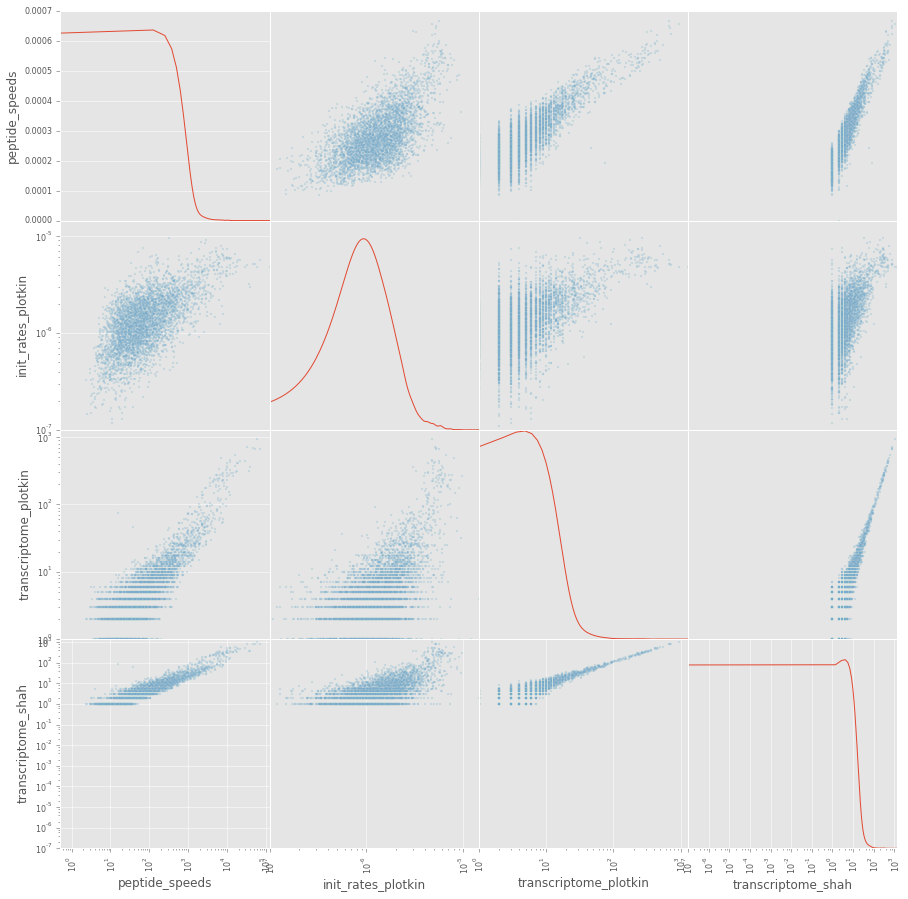

In [24]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0000001, df[df.columns[i+1]].min())
        minj = max(0.0000001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs.

The following is smaller than 20000 (or 60000), probably because not for every gene in `transcriptome_plotkin_20000.p` there is an initiation rate available.

In [25]:
len(results['transcriptome'])

57508

In [26]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [28]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

In [29]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [30]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [31]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [32]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [33]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic_toc']

In [34]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [35]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [36]:
pd.Series(orf_lengths.values()).describe()

count     5917.000000
mean      1485.306236
std       1149.149051
min         51.000000
25%        711.000000
50%       1218.000000
75%       1887.000000
max      14733.000000
dtype: float64

In [37]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'orf_length']

In [38]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

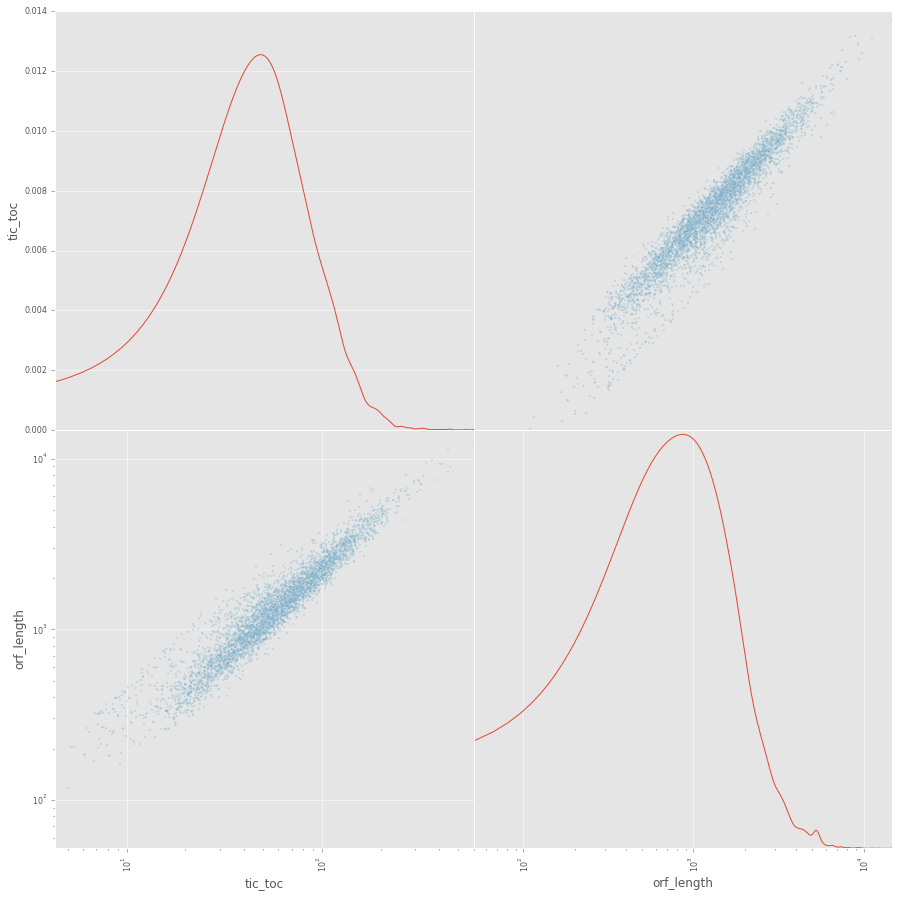

In [39]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')

In [40]:
ribo_inverse_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [41]:
pd.Series(ribo_inverse_speed_dict.values()).describe()

count    4475.000000
mean        0.044259
std         0.008225
min         0.019006
25%         0.039472
50%         0.044455
75%         0.049506
max         0.079996
dtype: float64

Distribution of inverse ribosome speeds (seconds per nucleotide):

(array([   6.,   11.,   12.,   26.,   26.,   14.,   25.,   25.,   36.,
          29.,   37.,   31.,   51.,   42.,   81.,   86.,   86.,  126.,
         122.,  158.,  178.,  218.,  227.,  228.,  250.,  239.,  237.,
         218.,  192.,  231.,  207.,  166.,  168.,  123.,  122.,   80.,
          77.,   49.,   45.,   44.,   27.,   25.,   28.,   15.,    7.,
           8.,    9.,    5.,    4.,    5.,    3.,    1.,    1.,    2.,
           2.,    2.,    1.,    0.,    0.,    0.]),
 array([ 0.0190063,  0.0200063,  0.0210063,  0.0220063,  0.0230063,
         0.0240063,  0.0250063,  0.0260063,  0.0270063,  0.0280063,
         0.0290063,  0.0300063,  0.0310063,  0.0320063,  0.0330063,
         0.0340063,  0.0350063,  0.0360063,  0.0370063,  0.0380063,
         0.0390063,  0.0400063,  0.0410063,  0.0420063,  0.0430063,
         0.0440063,  0.0450063,  0.0460063,  0.0470063,  0.0480063,
         0.0490063,  0.0500063,  0.0510063,  0.0520063,  0.0530063,
         0.0540063,  0.0550063,  0.0560063,  0

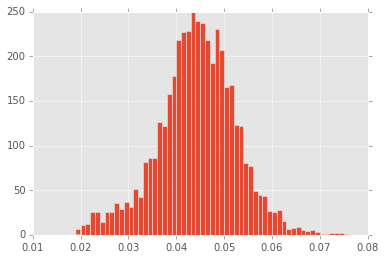

In [42]:
plt.hist(ribo_inverse_speed_dict.values(), bins=np.arange(min(ribo_inverse_speed_dict.values()), max(ribo_inverse_speed_dict.values()), 0.001))

In [43]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

Translation speed distribution (codons per second):

(array([   8.,   32.,  114.,  282.,  586.,  731.,  720.,  627.,  438.,
         270.,  178.,  130.,   71.,   48.,   51.,   32.,   28.,   26.,
          16.,   15.,   27.,   16.,   10.,    5.,    8.,    3.]),
 array([  4.1668845,   4.6668845,   5.1668845,   5.6668845,   6.1668845,
          6.6668845,   7.1668845,   7.6668845,   8.1668845,   8.6668845,
          9.1668845,   9.6668845,  10.1668845,  10.6668845,  11.1668845,
         11.6668845,  12.1668845,  12.6668845,  13.1668845,  13.6668845,
         14.1668845,  14.6668845,  15.1668845,  15.6668845,  16.1668845,
         16.6668845,  17.1668845]),
 <a list of 26 Patch objects>)

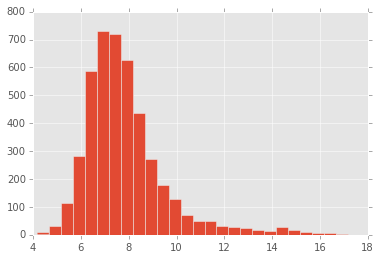

In [44]:
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5))

Broadly in line with bionumbers: 1-10 codons per second

http://bionumbers.hms.harvard.edu/search.aspx?log=y&task=searchbytrmorg&trm=ribosome+rate&time=2015%2f09%2f25+08%3a06%3a19.092

TODO: Check against CAI

### 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon

Can depend on:

a) time - zero at first, reaches steady state (not discussed further)

b) position - density might be high at 5' end if initation rate is higher than rate at which ribosomes are transported away from initiation site

In [48]:
import shelve

filepath = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151006_1537.db"
d = shelve.open(filepath)

Populate a dictionary with ribosome "lattices":

In [49]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

To make the ribosomes into a data frame, all array have to have the same length:

In [50]:
max_codons = len(max(ribo_lattice_dict.values(), key=len))

for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [51]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)
ribo_lattice_df[:15]

,YAL001C,YAL002W,YAL003W,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,YAL013W,YAL014C,YAL015C,YAL016W,YAL017W,YAL019W,YAL020C,YAL021C,YAL022C,YAL023C,YAL024C,
0,0,0,8,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...
1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
2,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
3,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...
5,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
6,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
7,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...
8,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...
9,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...


Check number of ribosomes in this data frame:

In [52]:
sum(dict(ribo_lattice_df.sum()).values())

162613.0

It is more convenient to remove the `None` values from `ribo_lattice_dict`:

In [53]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

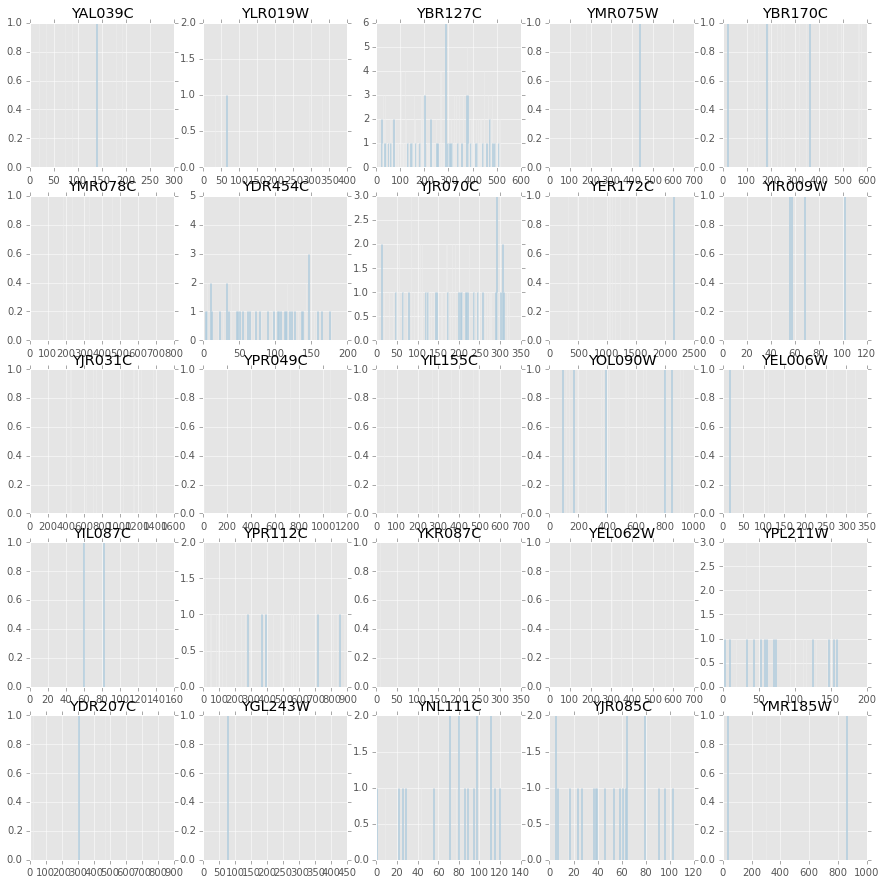

In [54]:
size = 5
genenames_plot = np.array(random.sample(ribo_lattice_dict.keys(), size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(15, 15))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]]]
        ax[i, j].bar(range(len(plotlist)), plotlist)
        ax[i, j].set_title(genenames_plot[i][j])

Average ribosome number per gene (average along the mRNA, across all codons):

In [55]:
average_ribos_per_gene = dict(ribo_lattice_df.mean(numeric_only=None))

Scatter plot against ORF lengths (mostly to rule out a mistake with the different lengths):

4340


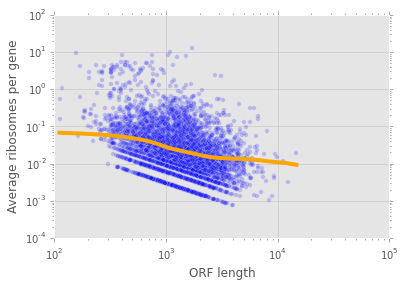

In [56]:
scatter_dicts(orf_lengths, {gene: average_ribos_per_gene[gene] for gene in average_ribos_per_gene 
                                if average_ribos_per_gene[gene] > 1e-16}, 'ORF length', 'Average ribosomes per gene')

No recognizable correlation - probably correct!

This means dividing by the length takes care of the correlation.

Normalize by transcript abundance:

In [57]:
transcriptome = pkl.load(open("../parameters/transcriptome_plotkin.p", "rb"))

In [58]:
print len(transcriptome)
print sum(transcriptome.values())

4839
60000


In [59]:
average_ribos_per_transcript = {gene: np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

In [60]:
total_ribos_per_transcript = {gene: sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

Plot against ORF length:

4340


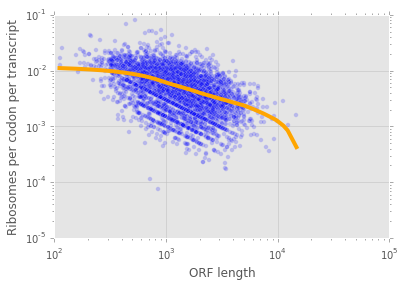

In [61]:
scatter_dicts(orf_lengths, average_ribos_per_transcript, 'ORF length', 'Ribosomes per codon per transcript')

4340


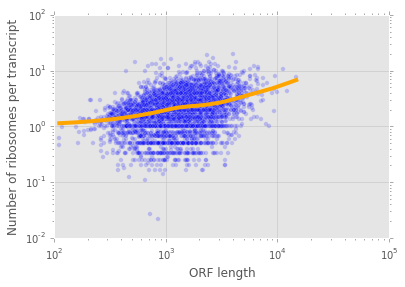

In [62]:
scatter_dicts(orf_lengths, total_ribos_per_transcript, 'ORF length', 'Number of ribosomes per transcript')

This is a relatively weak dependence because shorter genes have higher initiation rates which counteracts the (expected) length effect.

Plot against initiation rate:

4340


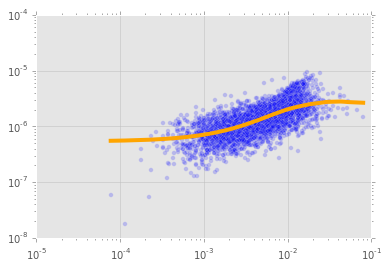

In [63]:
scatter_dicts(average_ribos_per_transcript, init_rates_plotkin)

2490


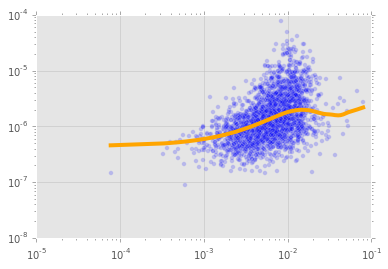

In [64]:
scatter_dicts(average_ribos_per_transcript, init_rates_plotkin_old)

TODO: what explains the remaining dispersion? TODO: check CAI?

Analysis by codon position:

In [65]:
ribo_lattice_df_normalized = pd.DataFrame()

for column in ribo_lattice_df:
    ribo_lattice_df_normalized[column] = ribo_lattice_df[column]/float(transcriptome[column])

In [66]:
means_per_position = ribo_lattice_df_normalized.mean(axis=1, numeric_only=None)
means_per_position

0     0.007479
1     0.006491
2     0.006815
3     0.005104
4     0.005861
5     0.006152
6     0.006053
7     0.006955
8     0.006547
9     0.006283
10    0.006311
11    0.006155
12    0.007617
13    0.005830
14    0.006725
...
4896    0
4897    0
4898    0
4899    0
4900    0
4901    0
4902    0
4903    0
4904    0
4905    0
4906    0
4907    0
4908    0
4909    0
4910    0
Length: 4911, dtype: float64

In [67]:
positions = len(means_per_position)
# not all genes in the transcriptome have an orf_length, why?
transcripts_per_position = [sum([transcriptome[gene] for gene in transcriptome 
                            if gene in orf_lengths and position+1 <= orf_lengths[gene]/3])
                            for position in range(positions)]
len(transcripts_per_position)

4911

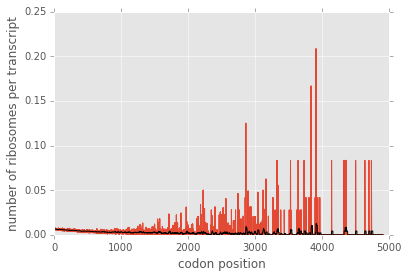

In [68]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
#plt.xlim([0, 500])
#plt.ylim([0, 0.01])
#plt.yscale('log') 
pd.rolling_mean(ts, 20).plot(style='k')

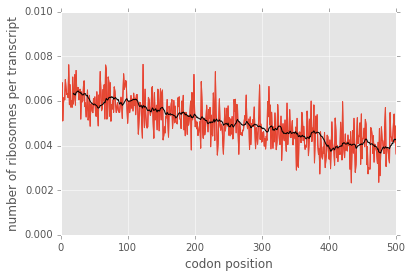

In [69]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
plt.xlim([0, 500])
plt.ylim([0, 0.01])
pd.rolling_mean(ts, 20).plot(style='k')

Let us try on single genes:

Find gene with maximum transcription (for best statistics):

In [70]:
maxgene = max(transcriptome.iterkeys(), key=(lambda key: transcriptome[key]))
maxgene, transcriptome[maxgene]

('YLR044C', 1283)

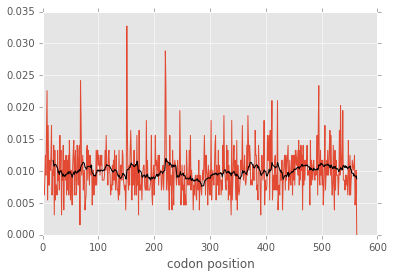

In [71]:
ribo_lattice_df_normalized[maxgene].plot().set_xlabel('codon position')
pd.rolling_mean(ribo_lattice_df_normalized[maxgene], 20).plot(style='k')

No ribosome ramp at individual gene level? This would be consistent with Shah's hypothesis that it is caused by short genes with high initiation probabilities. 

TODO: we need to check this more systematically.

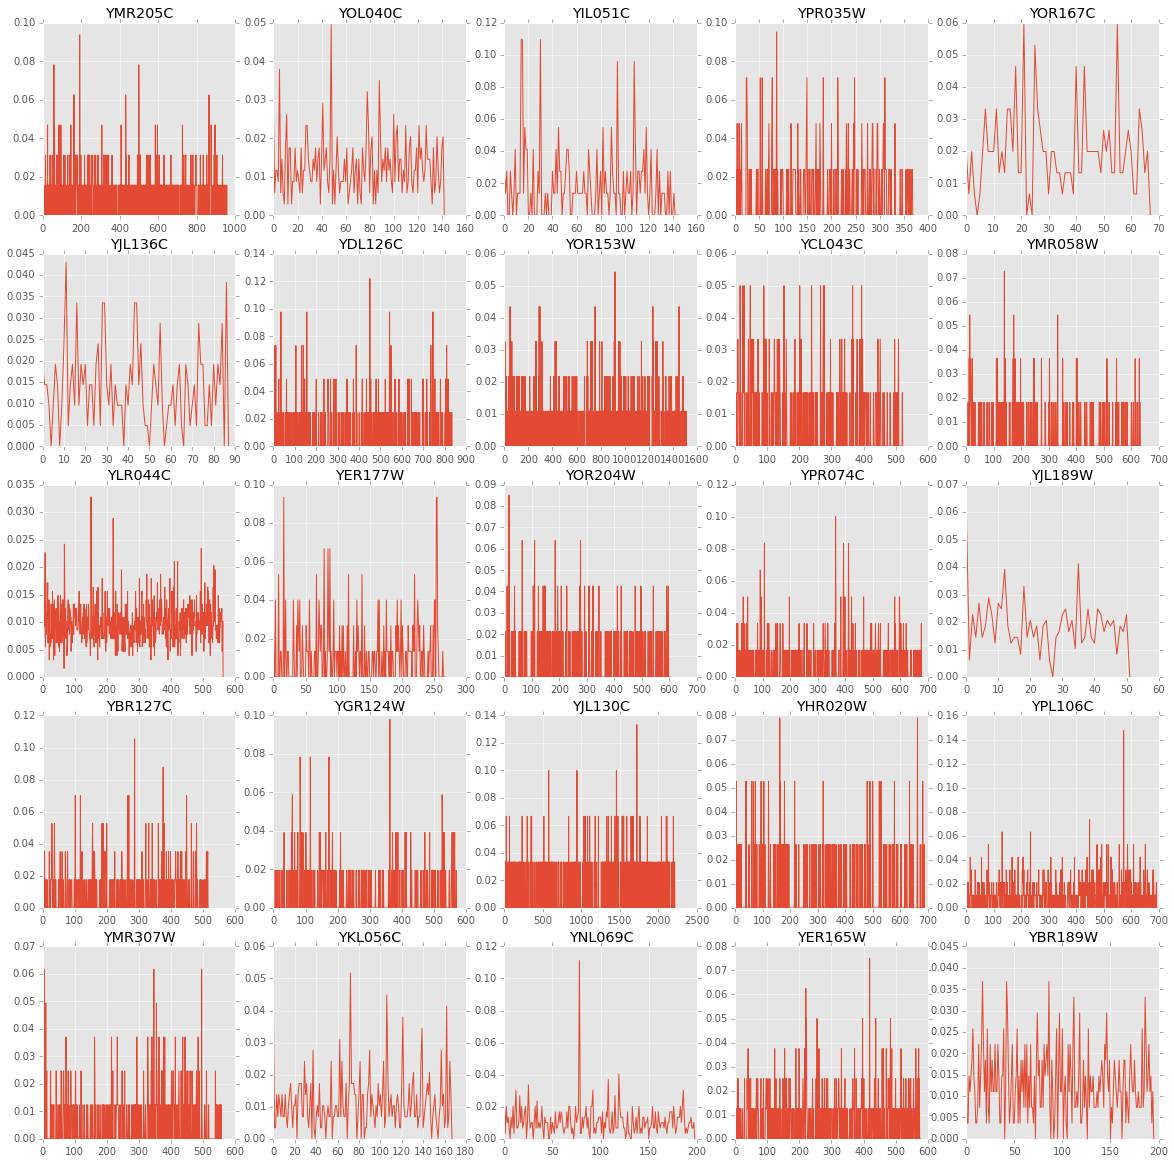

In [72]:
high_transcript_abundance_genes = [gene for gene in ribo_lattice_dict 
                                   if sum([elem for elem in ribo_lattice_dict[gene]]) > 150]

size = 5
genenames_plot = np.array(random.sample(high_transcript_abundance_genes, size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]] if elem is not None]
        ax[i, j].plot(ribo_lattice_df_normalized[genenames_plot[i][j]])
        #ax[i, j].set_xlabel('codon position')
        ax[i, j].set_title(genenames_plot[i][j])

To calculate the SNR, we establish standard deviations and maxima of the ribosome densities:

In [73]:
sigmas = {gene: np.std(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}
means = {gene: np.mean(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}

Find all peaks where the signal to noise ratio is greater than a predefined threoshold:

In [74]:
threshold = 5  # this many standard deviations above the mean are required for a signal to be classified as a peak

peaks = {gene: [(pos, value, (value - means[gene]) / sigmas[gene]) for (pos, value) 
                in enumerate(ribo_lattice_df_normalized[gene]) if (value - means[gene]) / sigmas[gene] > threshold] 
         for gene in sigmas if sigmas[gene] != 0
         }
        # and gene in high_transcript_abundance_genes}  # delete this to include all genes

In [75]:
peaks['YDL130W'], peaks['YBR078W']

([], [(410, 0.0975609756097561, 6.7217554767239953)])

Find out which codons are typically at peaks (hypothesis is that these might be rare codons):

In [76]:
from translation.TRSL_specific import codon_anticodon, tRNA_types, chunker, complement

In [77]:
codons_at_peaks = {gene: [orf_genomic_dict[gene][elem[0]*3:elem[0]*3+3] for elem in peaks[gene]] for gene in peaks}

In [78]:
anticodons_at_peaks = {gene: [codon_anticodon[codon] for codon in codons_at_peaks[gene]]
                       for gene in codons_at_peaks}

Define auxiliary function:

In [79]:
from itertools import chain

def flatten_dict_values(dictionary):
    return list(chain(*dictionary.values()))

In [80]:
from collections import Counter

counter = Counter(flatten_dict_values(anticodons_at_peaks))

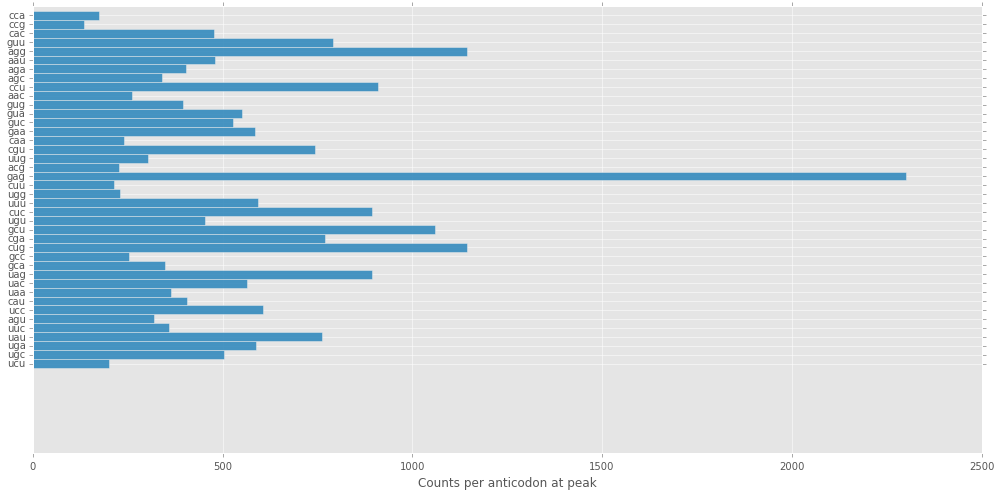

In [81]:
keys = counter.keys()
y_pos = np.arange(len(keys))*5

# get the counts for each key, assuming the values are numerical
counts = counter.values()

plt.figure(figsize=(17,8))
plt.barh(y_pos, counts, align='center', height=5, alpha=0.9)
plt.yticks(y_pos, keys)
plt.xlabel('Counts per anticodon at peak')

plt.show()

TODO: does this become more pronounced if restricted to high abundance proteins?

In [82]:
anticodon_tRNA_abundancy = {tRNA_types[id]['anticodon']: tRNA_types[id]['abundancy'] for id in tRNA_types}

40


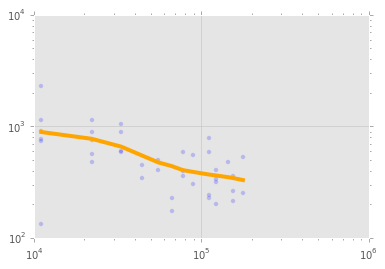

In [83]:
scatter_dicts(anticodon_tRNA_abundancy, counter)

The more tRNAs are available for an anticodon, the fewer peaks happen at these anticodons. Note the log axes.

Anticodon frequency at peaks compared to overall anticodon frequency in _transcriptome_:

The following list contains mRNA sequences times their occurrence in the transcriptome:

In [84]:
transcriptome_weighted_orfs = [orf_genomic_dict[gene] * transcriptome[gene] for gene in transcriptome 
                               if gene in orf_genomic_dict]

These must be converted to anticodons:

In [85]:
anticodon_demand_transcriptome = Counter([codon_anticodon[item] for sublist in [list(chunker(sequence, 3)) 
                                          for sequence in transcriptome_weighted_orfs] 
                                              for item in sublist])
anticodon_demand_transcriptome

Counter({'guc': 1318685, 'agc': 1297823, 'uuc': 1237162, 'aau': 1213382, 'guu': 1185186, 'aac': 1150281, 'gcc': 1137794, 'cuu': 1014643, 'aga': 1007867, 'gaa': 957780, 'agu': 949328, 'caa': 906955, 'gua': 731346, 'uuu': 723006, 'uug': 660947, 'ugg': 639681, 'ucu': 624873, 'uaa': 507318, 'gug': 466074, 'cau': 461897, 'uag': 383248, 'ugc': 362061, 'gcu': 353475, 'agg': 337310, 'cuc': 316850, 'uga': 273512, 'ugu': 263717, 'ucc': 243785, 'gca': 240562, 'gag': 240462, 'cca': 232589, 'acg': 227026, 'uau': 217816, 'cug': 176178, 'cac': 175980, 'uac': 168920, 'ccu': 128843, 'cga': 117809, 'cgu': 107840, '*': 57558, 'ccg': 17284})

41


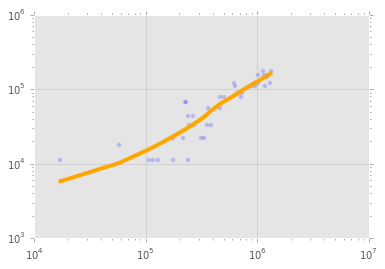

In [86]:
scatter_dicts(anticodon_demand_transcriptome, anticodon_tRNA_abundancy)

This is model-free, i.e. only transcriptome vs abundancies.

40


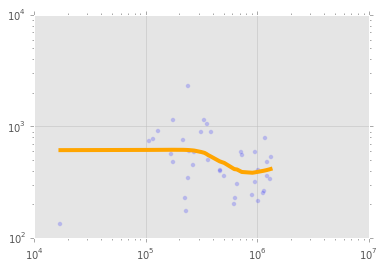

In [87]:
scatter_dicts(anticodon_demand_transcriptome, counter)

### 4. Number of free ribosomes

(0, 70000)

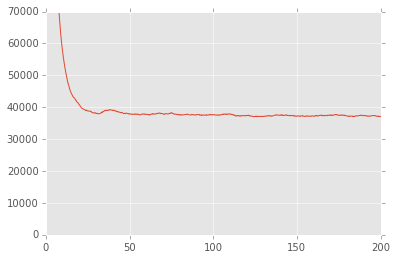

In [89]:
plt.plot(results["timerange"], results["timecourses"]["ribos._free"])
plt.xlim([0, 200])
plt.ylim([0, 70000])

There is a slight oscillation visible at the beginning that washes out towards the end.

In [90]:
results["timecourses"]["ribos._free"][-1] / 200000.

0.186935

19 % free ribosomes. (Shah et al. paper has 15%.)